# LIDAR feature extraction and discrete representation using Auto-Encoders

Import basic libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

Tune the knobs as you wish.

In [5]:
args = {'batch_size': 256,
        'epochs': 10,
        'device': 'cpu',
        'log_interval': 100,
        'data_distribution': 'bernoulli',
        'samples': 120000,
        'train_test_split': 0.25,
        'lr': 1e-5,
        'n_latents': 6,
        'latent_dim': 30,
        'categorical_dim': 5,
        'optimizer': 'adam',
        'reduction': 'mean',
        'temp_min': 0.5,
        'temp_start': 1.0,
        'features': 320}

Load the data.

train:  90000  test:  30000


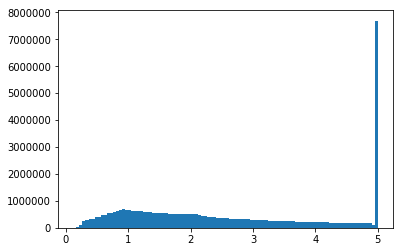

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import transforms

from utils import LIDARDataset, RandomRoll, RandomFlip, CropFeatures


# add custom transforms here
data_transform = transforms.Compose([RandomFlip(),
                                     RandomRoll(int(args["features"]/2)),
                                     CropFeatures(args["features"])])

# add maps for which data is available
maps = ['map1', 'map2', 'map3']
n = int(args["samples"]/len(maps))
map_data = pd.read_csv(maps[0]+"_lidar_data.csv",
                       index_col=False).drop(['v', 'w'], axis=1).dropna().sample(n)

# load data for each map and concatenate
for m in maps[1:]:
    mp = pd.read_csv(m+"_lidar_data.csv",
                    index_col=False).drop(['v', 'w'], axis=1).dropna().sample(n)
    map_data = map_data.append(mp)
    
# split into training and test sets
map_train_data, map_test_data = train_test_split( map_data,
                                                 test_size = args["train_test_split"] )

# load the data into a pytorch dataset class
train_dataset = LIDARDataset(data = map_train_data,
                             features = args["features"],
                             transform = data_transform)
test_dataset = LIDARDataset(data = map_test_data,
                            features = args["features"],
                            transform = data_transform)

# pytorch dataloader for fetching batches during training
train_loader = DataLoader(train_dataset, batch_size = args["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = args["batch_size"], shuffle=True)

# print data size and distribution
print("train: ", len(train_loader.dataset), " test: ", len(test_loader.dataset))
plt.hist(map_data.values.flatten(), bins=100);

# Auto-Encoder

Instantiate, train and save an Auto-Encoder.

In [4]:
from autoencoders import AutoEncoder
from solver import trainer

modelAE = AutoEncoder(data_distribution = args["data_distribution"],
                           input_dim = args["features"],
                           z_dim = args["latent_dim"]).to(args["device"])

modelAE, train_logs, test_logs = trainer(modelAE, args['epochs'], train_loader, test_loader, args)
torch.save(modelAE, "AutoEncoder.pytorch", pickle_protocol=2)

====> Test set loss: 0.7055
Train Epoch: 1 [0/90000 (0%)]	Loss: 0.782581
Train Epoch: 1 [25600/90000 (28%)]	Loss: 0.662271
Train Epoch: 1 [51200/90000 (57%)]	Loss: 0.580412
Train Epoch: 1 [76800/90000 (85%)]	Loss: 0.541514
====> Epoch: 1 Average loss: 0.6178
====> Test set loss: 0.5366
Train Epoch: 2 [0/90000 (0%)]	Loss: 0.525589
Train Epoch: 2 [25600/90000 (28%)]	Loss: 0.524023
Train Epoch: 2 [51200/90000 (57%)]	Loss: 0.520546
Train Epoch: 2 [76800/90000 (85%)]	Loss: 0.499667
====> Epoch: 2 Average loss: 0.5148
====> Test set loss: 0.5063
Train Epoch: 3 [0/90000 (0%)]	Loss: 0.498314
Train Epoch: 3 [25600/90000 (28%)]	Loss: 0.498254
Train Epoch: 3 [51200/90000 (57%)]	Loss: 0.496222
Train Epoch: 3 [76800/90000 (85%)]	Loss: 0.494550
====> Epoch: 3 Average loss: 0.4984
====> Test set loss: 0.4949
Train Epoch: 4 [0/90000 (0%)]	Loss: 0.496594
Train Epoch: 4 [25600/90000 (28%)]	Loss: 0.487009
Train Epoch: 4 [51200/90000 (57%)]	Loss: 0.488205
Train Epoch: 4 [76800/90000 (85%)]	Loss: 0.483269


Plot the loss, ELBO and negative reconstruction error (for a simple auto-encoder, the later two are just the negative of the loss).

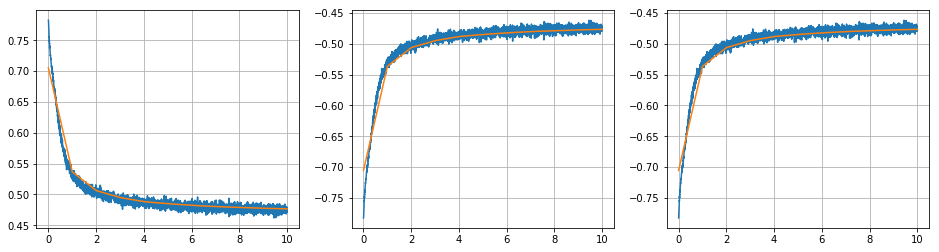

In [6]:
from misc import plot_loss_graphs as plt_loss
plt_loss((train_logs, test_logs), args);
logs = [(train_logs, test_logs)]

See the reconstruction of a random sample from the test set.

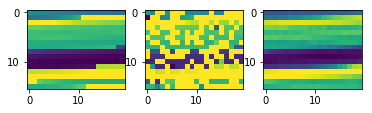

In [53]:
from misc import test_random_sample as test_sample
test_sample(modelAE, test_loader, args);

Visualize the test set latent space by embedding (UMAP) latents further down to 2D (NOTE: this is only for visualization purposes).

matrix dimensions:  (30000, 30)
rank:  30


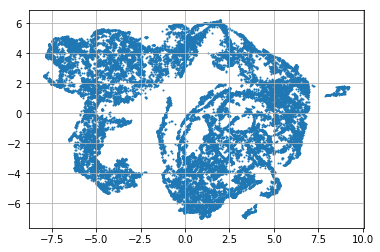

In [8]:
from misc import visualize_latents
visualize_latents(modelAE, test_dataset, args);

# Variational Auto-Encoder (VAE)

Instantiate, train and save a VAE.

In [9]:
from autoencoders import VAE

modelVAE = VAE(data_distribution = args["data_distribution"],
                           input_dim = args["features"],
                           z_dim = args["latent_dim"]).to(args["device"])

modelVAE.encoder[:-1].load_state_dict(modelAE.encoder[:-1].state_dict())
modelVAE.decoder[1:].load_state_dict(modelAE.decoder[1:].state_dict())

# modelVAE.encoder[-1].block[0].weight.data[:args["latent_dim"], :, :].copy_(modelAE.encoder[-1].block[0].weight.data);
# modelVAE.encoder[-1].block[0].bias.data[:args["latent_dim"]].copy_(modelAE.encoder[-1].block[0].bias.data);
# modelVAE.encoder[-1].block[0].weight.data[args["latent_dim"]:, :, :].copy_(torch.randn_like(modelAE.encoder[-1].block[0].weight.data).data*0.001);
# modelVAE.encoder[-1].block[0].bias.data[args["latent_dim"]:].copy_(torch.zeros_like(modelAE.encoder[-1].block[0].bias.data).data);

modelVAE, train_logs, test_logs = trainer(modelVAE, args['epochs'], train_loader, test_loader, args)
torch.save(modelVAE, "VAE.pytorch", pickle_protocol=2)

====> Test set loss: 0.7513
Train Epoch: 1 [0/90000 (0%)]	Loss: 1.258230
Train Epoch: 1 [25600/90000 (28%)]	Loss: 1.166273
Train Epoch: 1 [51200/90000 (57%)]	Loss: 1.094387
Train Epoch: 1 [76800/90000 (85%)]	Loss: 1.016694
====> Epoch: 1 Average loss: 1.1201
====> Test set loss: 0.8318
Train Epoch: 2 [0/90000 (0%)]	Loss: 0.964277
Train Epoch: 2 [25600/90000 (28%)]	Loss: 0.923365
Train Epoch: 2 [51200/90000 (57%)]	Loss: 0.873460
Train Epoch: 2 [76800/90000 (85%)]	Loss: 0.844744
====> Epoch: 2 Average loss: 0.8950
====> Test set loss: 0.8244
Train Epoch: 3 [0/90000 (0%)]	Loss: 0.842966
Train Epoch: 3 [25600/90000 (28%)]	Loss: 0.824565
Train Epoch: 3 [51200/90000 (57%)]	Loss: 0.820031
Train Epoch: 3 [76800/90000 (85%)]	Loss: 0.792400
====> Epoch: 3 Average loss: 0.8186
====> Test set loss: 0.7869
Train Epoch: 4 [0/90000 (0%)]	Loss: 0.797751
Train Epoch: 4 [25600/90000 (28%)]	Loss: 0.780490
Train Epoch: 4 [51200/90000 (57%)]	Loss: 0.767614
Train Epoch: 4 [76800/90000 (85%)]	Loss: 0.755344


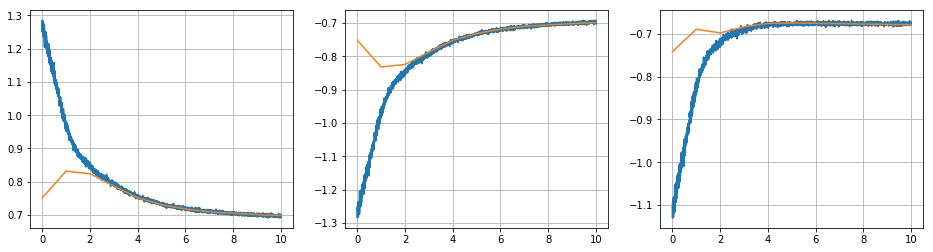

In [10]:
plt_loss((train_logs, test_logs), args);
logs.append((train_logs, test_logs))

See the reconstruction of a random sample from the test set.

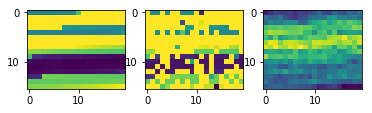

In [50]:
test_sample(modelVAE, test_loader, args);

Visualize the test set latent space by embedding (UMAP) latents further down to 2D (NOTE: this is only for visualization purposes).

matrix dimensions:  (30000, 30)
rank:  30


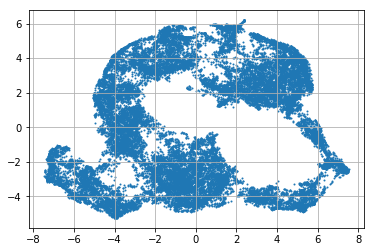

In [12]:
visualize_latents(modelVAE, test_dataset, args);

# Gumbel-Softmax VAE

Instantiate, train and save a VAE with Gumbel-Softmax reparameterization trick.

In [13]:
from autoencoders import GumbelVAE

modelGVAE = GumbelVAE(data_distribution = args["data_distribution"],
                           input_dim = args["features"],
                           latent_dim = args["n_latents"],
                           categorical_dim = args["categorical_dim"]).to(args["device"])

modelGVAE.encoder[:-1].load_state_dict(modelAE.encoder[:-1].state_dict())
modelGVAE.decoder[1:].load_state_dict(modelAE.decoder[1:].state_dict())

modelGVAE, train_logs, test_logs = trainer(modelGVAE, args['epochs'], train_loader, test_loader, args)
torch.save(modelGVAE, "GumbelVAE.pytorch", pickle_protocol=2)

====> Test set loss: 0.7750
Anneal rate set to:  0.00022684877733459422
Train Epoch: 1 [0/90000 (0%)]	Loss: 1.092128
Train Epoch: 1 [25600/90000 (28%)]	Loss: 0.982845
Train Epoch: 1 [51200/90000 (57%)]	Loss: 0.924855
Train Epoch: 1 [76800/90000 (85%)]	Loss: 0.835534
Temp:  0.9232541136674268
====> Epoch: 1 Average loss: 0.9354
====> Test set loss: 0.9117
Train Epoch: 2 [0/90000 (0%)]	Loss: 0.800216
Train Epoch: 2 [25600/90000 (28%)]	Loss: 0.768058
Train Epoch: 2 [51200/90000 (57%)]	Loss: 0.746869
Train Epoch: 2 [76800/90000 (85%)]	Loss: 0.725715
Temp:  0.8523981584038258
====> Epoch: 2 Average loss: 0.7551
====> Test set loss: 0.7533
Train Epoch: 3 [0/90000 (0%)]	Loss: 0.723405
Train Epoch: 3 [25600/90000 (28%)]	Loss: 0.701217
Train Epoch: 3 [51200/90000 (57%)]	Loss: 0.705388
Train Epoch: 3 [76800/90000 (85%)]	Loss: 0.699034
Temp:  0.786980106228871
====> Epoch: 3 Average loss: 0.7076
====> Test set loss: 0.7086
Train Epoch: 4 [0/90000 (0%)]	Loss: 0.692443
Train Epoch: 4 [25600/90000 (

Plot loss, ELBO and negative reconstruction error (Similar to a normal VAE, for a GumbelVAE, the loss is the negative of ELBO).

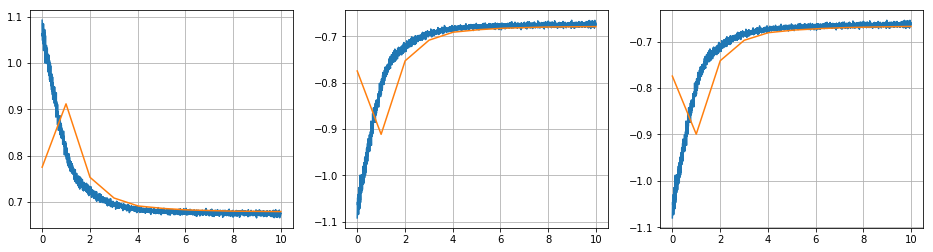

In [14]:
plt_loss((train_logs, test_logs), args);
logs.append((train_logs, test_logs))

See the reconstruction of a random sample from the test set along with its (enumerated) discrete latent/label.

Discrete Label:  tensor(12409, dtype=torch.int32)


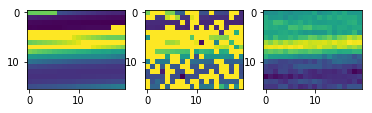

In [45]:
test_sample(modelGVAE, test_loader, args);

Visualize the test set latent space by embedding (UMAP) latents further down to 2D and coloring with the corresponding discrete encoding. The corresponding discrete latent distribution is shown on the right (NOTE: this is only for visualization purposes). The 'capacity' used to represent the test set is also shown.

matrix dimensions:  (30000, 30)
rank:  25
num codes used: 1151/15624 (7.366871479774706%)


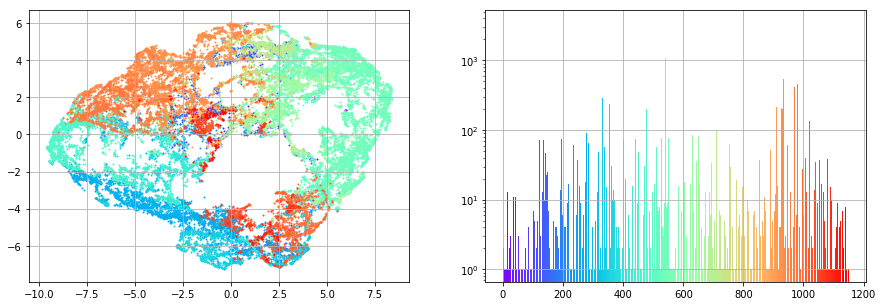

In [17]:
visualize_latents(modelGVAE, test_dataset, args);

# Vector Quantized VAE (VQ-VAE)

Instantiate, train and save a VQ-VAE.

In [18]:
from autoencoders import VectorQuantizedVAE

modelVQVAE = VectorQuantizedVAE(data_distribution = args["data_distribution"],
                           input_dim = args["features"],
                           latent_dim = args["latent_dim"],
                           n_latents = args["n_latents"],
                           categorical_dim = args["categorical_dim"]).to(args["device"])

modelVQVAE.encoder[:len(modelVQVAE.encoder)-1].load_state_dict(modelAE.encoder[:len(modelVQVAE.encoder)-1].state_dict())
modelVQVAE.decoder[1:len(modelVQVAE.decoder)-2].load_state_dict(modelAE.decoder[1:len(modelVQVAE.decoder)-2].state_dict())

modelVQVAE, train_logs, test_logs = trainer(modelVQVAE, args['epochs'], train_loader, test_loader, args)
torch.save(modelVQVAE, "VQVAE.pytorch", pickle_protocol=2)

====> Test set loss: 0.7982
Train Epoch: 1 [0/90000 (0%)]	Loss: 1.256353
Train Epoch: 1 [25600/90000 (28%)]	Loss: 1.227125
Train Epoch: 1 [51200/90000 (57%)]	Loss: 1.192061
Train Epoch: 1 [76800/90000 (85%)]	Loss: 1.150474
====> Epoch: 1 Average loss: 1.1971
====> Test set loss: 1.1397
Train Epoch: 2 [0/90000 (0%)]	Loss: 1.139363
Train Epoch: 2 [25600/90000 (28%)]	Loss: 1.112615
Train Epoch: 2 [51200/90000 (57%)]	Loss: 1.097616
Train Epoch: 2 [76800/90000 (85%)]	Loss: 1.073690
====> Epoch: 2 Average loss: 1.0992
====> Test set loss: 1.0860
Train Epoch: 3 [0/90000 (0%)]	Loss: 1.065064
Train Epoch: 3 [25600/90000 (28%)]	Loss: 1.058168
Train Epoch: 3 [51200/90000 (57%)]	Loss: 1.032440
Train Epoch: 3 [76800/90000 (85%)]	Loss: 1.032414
====> Epoch: 3 Average loss: 1.0471
====> Test set loss: 1.0316
Train Epoch: 4 [0/90000 (0%)]	Loss: 1.036519
Train Epoch: 4 [25600/90000 (28%)]	Loss: 1.018835
Train Epoch: 4 [51200/90000 (57%)]	Loss: 1.002985
Train Epoch: 4 [76800/90000 (85%)]	Loss: 1.004404


Plot loss, ELBO and negative reconstruction error (For a VQ-VAE, the loss is the sum of negative ELBO, 'VQ-loss' and 'commitment loss', from which the later two are not shown here).

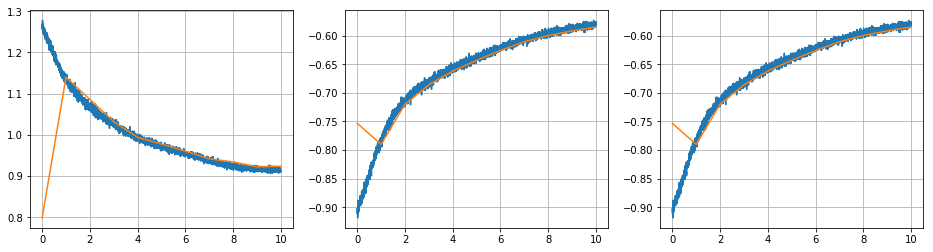

In [19]:
plt_loss((train_logs, test_logs), args);
logs.append((train_logs, test_logs))

See the reconstruction of a random sample from the test set along with its (enumerated) discrete latent/label.

Discrete Label:  tensor(2374, dtype=torch.int32)


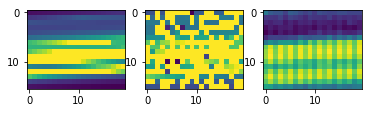

In [30]:
test_sample(modelVQVAE, test_loader, args);

Visualize the test set latent space by embedding (UMAP) latents further down to 2D and coloring with the corresponding discrete encoding. The corresponding discrete latent distribution is shown on the right (NOTE: this is only for visualization purposes). The 'capacity' used to represent the test set is also shown.

matrix dimensions:  (30000, 180)
rank:  180
num codes used: 2639/15624 (16.89068100358423%)


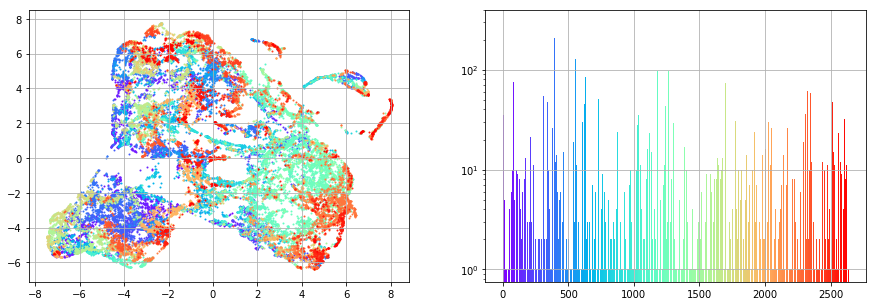

In [21]:
visualize_latents(modelVQVAE, test_dataset, args);

# Compare ELBO and Negative Reconstruction Error

Compare the test-set loss/ELBO/negative reconstruction error graphs all variants of Auto-Encders. Note however, that only ELBO and negative reconstruction error is comparable and the over-all loss might not be comparable for all suto-encoders and is only presented here for completeness.

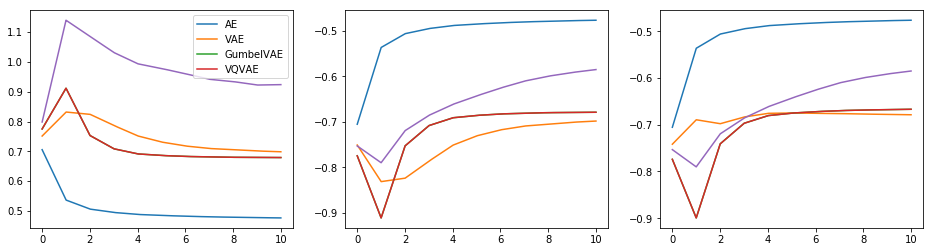

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for i, (train_logs, test_logs) in enumerate(logs):
    plt_loss((train_logs, test_logs), args, train=False, fig=fig, ax=ax);
ax[0].grid(), ax[1].grid(), ax[2].grid()
ax[0].legend(['AE', 'VAE', 'GumbelVAE', 'VQVAE'])

***